<h1><center><font size="6">Preprocessing Notebook</font></center></h1>

In [124]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import re as regex
import pickle
import datetime
import plotly
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from plotly import graph_objs
import plotly.graph_objs as go
import chart_studio.plotly as py
plotly.offline.init_notebook_mode()
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text.tsne import tsne
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob, Word

from sklearn import linear_model
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours, RandomUnderSampler, TomekLinks, CondensedNearestNeighbour
from imblearn.combine import SMOTETomek, SMOTEENN

import multiprocessing
from gensim.models.doc2vec import TaggedDocument, LabeledSentence
from gensim.models import Word2Vec, Doc2Vec

%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("py/")
from utils import *
from config import keys
from preprocess import *

# Original Dataset


In [6]:
df = pd.read_csv("data/labeled_data.csv", index_col=0)
df.head()

count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [7]:
df.shape

(24783, 6)

In [8]:
df = df.rename(columns={"hate_speech": 'hate', "offensive_language": 'offensive', "neither": 'neutral', "class": 'target'})
df.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       2   
1      3     0          3        0       1   
2      3     0          3        0       1   
3      3     0          2        1       1   
4      6     0          6        0       1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [9]:
hate = len(df[df['target'] == 0])
off = len(df[df['target'] == 1])
neu = len(df[df['target'] == 2])
dist = [
    graph_objs.Bar(
        x=["hate","offensive","neutral"],
        y=[hate, off, neu],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Class Distribution")})

# EDA and Feature Engineering

In [10]:
df.tweet.head(30)

0     !!! RT @mayasolovely: As a woman you shouldn't...
1     !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2     !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3     !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6     !!!!!!"@__BrighterDays: I can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8     " &amp; you might not get ya bitch back &amp; ...
9     " @rhythmixx_ :hobbies include: fighting Maria...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

## Word Count Per Tweet

In [11]:
def num_of_words(df, col):
    df['word_ct'] = df[col].apply(lambda x: len(str(x).split(" ")))
    print(df[[col, 'word_ct']])

num_of_words(df, 'tweet')

                                                   tweet  word_ct
0      !!! RT @mayasolovely: As a woman you shouldn't...       25
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       16
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...       21
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        9
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...       26
...                                                  ...      ...
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...       19
25292  you've gone and broke the wrong heart baby, an...       13
25294  young buck wanna eat!!.. dat nigguh like I ain...       13
25295              youu got wild bitches tellin you lies        7
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...       18

[24783 rows x 2 columns]


In [12]:
df['word_ct'].iplot(
    kind='hist',
    bins=40,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution')

## Number of Characters Per Tweet

In [13]:
def num_of_chars(df, col):
    df['char_ct'] = df[col].str.len()
    print(df[[col, 'char_ct']])

num_of_chars(df, 'tweet')

                                                   tweet  char_ct
0      !!! RT @mayasolovely: As a woman you shouldn't...      140
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       85
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      120
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...       62
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      137
...                                                  ...      ...
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...      146
25292  you've gone and broke the wrong heart baby, an...       70
25294  young buck wanna eat!!.. dat nigguh like I ain...       67
25295              youu got wild bitches tellin you lies       37
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...      127

[24783 rows x 2 columns]


In [14]:
df['char_ct'].iplot(
    kind='hist',
    bins=100,
    xTitle='character count',
    linecolor='black',
    yTitle='count',
    title='Character Count Distribution')

## Average Word Length Per Tweet

In [15]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

def avg_word_length(df, col):
    df['avg_wrd'] = df[col].apply(lambda x: avg_word(x))
    print(df[[col, 'avg_wrd']].head())

avg_word_length(df, 'tweet')

                                               tweet   avg_wrd
0  !!! RT @mayasolovely: As a woman you shouldn't...  4.640000
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  4.375000
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  4.761905
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  6.000000
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  4.307692


In [16]:
df['avg_wrd'].iplot(
    kind='hist',
    bins=60,
    xTitle='average word length',
    linecolor='black',
    yTitle='count',
    title='Average Word Length Distribution')

## Hashtags Count

In [18]:
def hash_tags(df, col):
    df['hashtags'] = df[col].apply(lambda x: len(re.split(r'#', str(x)))-1)
    print(df[[col, 'hashtags']].head())

hash_tags(df, 'tweet')

                                               tweet  hashtags
0  !!! RT @mayasolovely: As a woman you shouldn't...         0
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...         0
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...         0
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...         0
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...         1


In [19]:
df['hashtags'].iplot(
    kind='hist',
    bins=100,
    xTitle='hashtags count',
    linecolor='black',
    yTitle='count',
    title='Number of Hashtags Distribution')

## Preprocessing Function and Feature Engineering

- Letter casing: Converting all letters to either upper case or lower case.
- Tokenizing: Turning the tweets into tokens. Tokens are words separated by spaces in a text.
- Noise removal: Eliminating unwanted characters, such as HTML tags, punctuation marks, special characters, white spaces etc.
- Stopword removal: Some words do not contribute much to the machine learning model, so it's good to remove them. A list of stopwords can be defined by the nltk library, or it can be business-specific.
- Normalization: Normalization generally refers to a series of related tasks meant to put all text on the same level. Converting text to lower case, removing special characters, and removing stopwords will remove basic inconsistencies. Normalization improves text matching.
- Stemming: Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from a word in order to obtain a word stem. Porter Stemmer is the most widely used technique because it is very fast. Generally, stemming chops off end of the word, and mostly it works fine. Example: Working -> Work
- Lemmatization: The goal is same as with stemming, but stemming a word sometimes loses the actual meaning of the word. Lemmatization usually refers to doing things properly using vocabulary and morphological analysis of words. It returns the base or dictionary form of a word, also known as the lemma. Example: Better -> Good.
    - Stemming is faster than lemmatization. You can uncomment the code and see how results change. Note: Do not apply both. Remember that stemming and lemmatization are normalization techniques, and it is recommended to use only one approach to normalize. Let your project requirements guide your decision, or you can always do experiments and see which one gives better results. In this case, stemming and lemmatizing yield almost the same accuracy.
- Vectorizing Data: Vectorizing is the process to convert tokens to numbers. It is an important step because the machine learning algorithm works with numbers and not text, such as vectorization using tf-idf, or Bag of Words and N-grams.

In [21]:
def preprocess_tweets(df, col):
    """master function to preprocess tweets"""
    collect_and_remove_users(df, col)
    collect_and_remove_charef(df, col)
    collect_and_remove_hashtags(df, col)
    collect_and_remove_links(df, col)
    remove_av_qt(df, col)
    remove_punctuation(df, col)
    lowercasing(df, col)
    remove_whitespaces(df, col)
    remove_numerics(df, col)
    tokenize_and_lemmatize(df, col)

preprocess_tweets(df, 'tweet')

In [90]:
df.head()

id    label
0  849667487180259329  abusive
1  850490912954351616  abusive
2  848791766853668864  abusive
3  848306464892604416  abusive
4  850010509969465344   normal

In [23]:
df.tweet.head()

0    [woman, shouldnt, complain, clean, house, man,...
1    [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...
2            [dawg, fuck, bitch, start, confuse, shit]
3                                 [look, like, tranny]
4               [shit, hear, true, faker, bitch, tell]
Name: tweet, dtype: object

## Assigning Target Variable

In [24]:
df2 = df.copy()

In [25]:
df2['target'].value_counts()

1    19190
2     4163
0     1430
Name: target, dtype: int64

In [26]:
df2['target'] = df2['target'].replace([2], 1)
df2['target'].value_counts()

1    23353
0     1430
Name: target, dtype: int64

In [27]:
df2.target = df2.target.replace([0, 1], [1, 0])
df2.target.value_counts()

0    23353
1     1430
Name: target, dtype: int64

In [28]:
hate = df2[df2.target == 1]
non_hate = df2[df2.target == 0]

## Train-Validation-Test Split

In [29]:
X_h = hate.tweet
y_h = hate.target
X_nh = non_hate.tweet
y_nh = non_hate.target

In [30]:
X_h_tr, X_h_val, y_h_tr, y_h_val = train_test_split(X_h, y_h, test_size=0.25, random_state=42)
X_h_val, X_h_tt, y_h_val, y_h_tt = train_test_split(X_h_val, y_h_val, test_size=0.4, random_state=42)
X_nh_tr, X_nh_val, y_nh_tr, y_nh_val = train_test_split(X_nh, y_nh, test_size=0.25, random_state=42)
X_nh_val, X_nh_tt, y_nh_val, y_nh_tt = train_test_split(X_nh_val, y_nh_val, test_size=0.4, random_state=42)

In [31]:
X_tr = pd.concat((X_h_tr, X_nh_tr), ignore_index=True)
y_tr = pd.concat((y_h_tr, y_nh_tr), ignore_index=True)
train = pd.concat([X_tr, y_tr], axis=1)
train.head()

tweet  target
0  [reject, constantly, house, threaten, rape, mo...       1
1  [convince, lame, nigger, liver, believe, cuz, ...       1
2  [peace, fag, remember, best, lux, support, dro...       1
3                    [haha, ight, nig, calm, yoself]       1
4  [tits, better, look, face, make, like, asian, ...       1

In [32]:
train['tweet2'] = train.tweet.apply(lambda x: str(x)[1:-1]) 
train.head()

tweet  target  \
0  [reject, constantly, house, threaten, rape, mo...       1   
1  [convince, lame, nigger, liver, believe, cuz, ...       1   
2  [peace, fag, remember, best, lux, support, dro...       1   
3                    [haha, ight, nig, calm, yoself]       1   
4  [tits, better, look, face, make, like, asian, ...       1   

                                              tweet2  
0  'reject', 'constantly', 'house', 'threaten', '...  
1  'convince', 'lame', 'nigger', 'liver', 'believ...  
2  'peace', 'fag', 'remember', 'best', 'lux', 'su...  
3            'haha', 'ight', 'nig', 'calm', 'yoself'  
4  'tits', 'better', 'look', 'face', 'make', 'lik...

In [34]:
X_val = pd.concat((X_h_val, X_nh_val), ignore_index=True)
y_val = pd.concat((y_h_val, y_nh_val), ignore_index=True)
val = pd.concat([X_val, y_val], axis=1)
val['tweet2'] = val.tweet.apply(lambda x: str(x)[1:-1]) 
val.head()

tweet  target  \
0  [lbum, fotos, gaywrites, make, project, queer,...       1   
1  [yay, america, israel, jew, hat, muslim, trash...       1   
2  [miss, ofay, friends, day, scar, recent, happe...       1   
3     [trash, darkskin, nigga, steal, damn, garbage]       1   
4      [cody, call, people, nigger, hes, fuck, spaz]       1   

                                              tweet2  
0  'lbum', 'fotos', 'gaywrites', 'make', 'project...  
1  'yay', 'america', 'israel', 'jew', 'hat', 'mus...  
2  'miss', 'ofay', 'friends', 'day', 'scar', 'rec...  
3  'trash', 'darkskin', 'nigga', 'steal', 'damn',...  
4  'cody', 'call', 'people', 'nigger', 'hes', 'fu...

In [35]:
X_tt = pd.concat((X_h_tt, X_nh_tt), ignore_index=True)
y_tt = pd.concat((y_h_tt, y_nh_tt), ignore_index=True)
test = pd.concat([X_tt, y_tt], axis=1)
test.head()

tweet  target
0                       [johnny, rebel, nigger, day]       1
1  [favorite, nigger, work, plantation, remember,...       1
2  [go, prestigious, establishments, clearly, sup...       1
3                       [westvirginia, white, trash]       1
4  [fuck, brett, farve, redneck, ass, stuckup, do...       1

## Separate into classes

In [36]:
zero = train[train.target == 0]
zero.head()

tweet  target  \
1072                                            [bitch]       0   
1073                 [take, bitch, months, scarf, smfh]       0   
1074  [kim, alright, honestly, niggas, miley, get, u...       0   
1075  [bitch, worry, fin, fuck, best, friend, get, j...       0   
1076  [end, ordination, women, faggot, aim, weaken, ...       0   

                                                 tweet2  
1072                                            'bitch'  
1073         'take', 'bitch', 'months', 'scarf', 'smfh'  
1074  'kim', 'alright', 'honestly', 'niggas', 'miley...  
1075  'bitch', 'worry', 'fin', 'fuck', 'best', 'frie...  
1076  'end', 'ordination', 'women', 'faggot', 'aim',...

In [37]:
one = train[train.target == 1]
one.head()

tweet  target  \
0  [reject, constantly, house, threaten, rape, mo...       1   
1  [convince, lame, nigger, liver, believe, cuz, ...       1   
2  [peace, fag, remember, best, lux, support, dro...       1   
3                    [haha, ight, nig, calm, yoself]       1   
4  [tits, better, look, face, make, like, asian, ...       1   

                                              tweet2  
0  'reject', 'constantly', 'house', 'threaten', '...  
1  'convince', 'lame', 'nigger', 'liver', 'believ...  
2  'peace', 'fag', 'remember', 'best', 'lux', 'su...  
3            'haha', 'ight', 'nig', 'calm', 'yoself'  
4  'tits', 'better', 'look', 'face', 'make', 'lik...

## Frequency Distributions

FrequencyVisualizer(ax=<AxesSubplot:>,
                    features=['aaahhhhh', 'aahahah', 'aaliyah', 'aamu', 'aan',
                              'aap', 'aaron', 'abandonado', 'abbey', 'abby',
                              'abc', 'abdelka', 'abduction', 'abdullah', 'abed',
                              'aberdeen', 'ability', 'able', 'abo', 'abort',
                              'abortion', 'abou', 'abound', 'abraham', 'abs',
                              'absent', 'absolute', 'absolutely',
                              'absoluteyvile', 'abstract', ...],
                    n=None, orient='v')

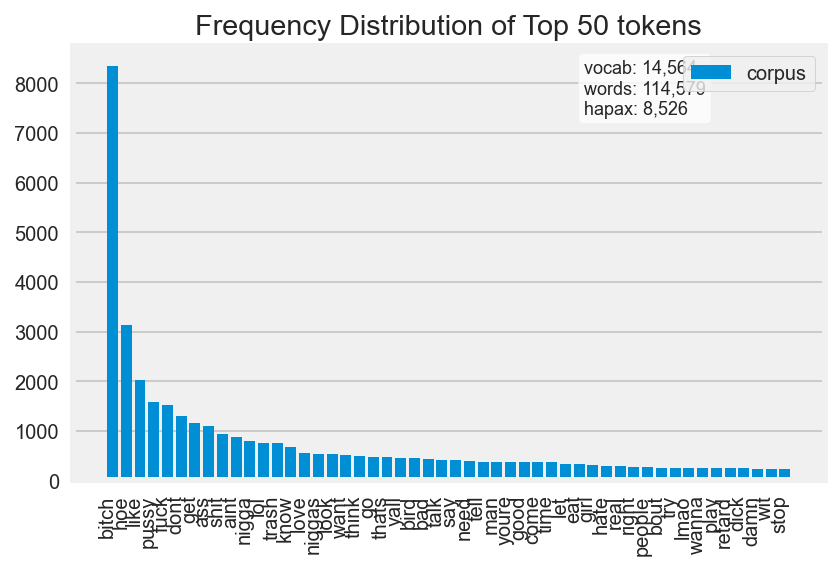

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [41]:
vec = CountVectorizer()
zero_tokens = zero.tweet.sum()
docs = vec.fit_transform(zero_tokens)
features = vec.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

FrequencyVisualizer(ax=<AxesSubplot:>,
                    features=['aap', 'absolve', 'abuse', 'accept', 'acceptable',
                              'accord', 'account', 'accuracy', 'act', 'actin',
                              'active', 'activities', 'activity', 'actual',
                              'actually', 'add', 'address', 'admit', 'ads',
                              'advice', 'affection', 'afford', 'aflcio',
                              'africa', 'african', 'age', 'agg', 'ago', 'agree',
                              'ahh', ...],
                    n=None, orient='v')

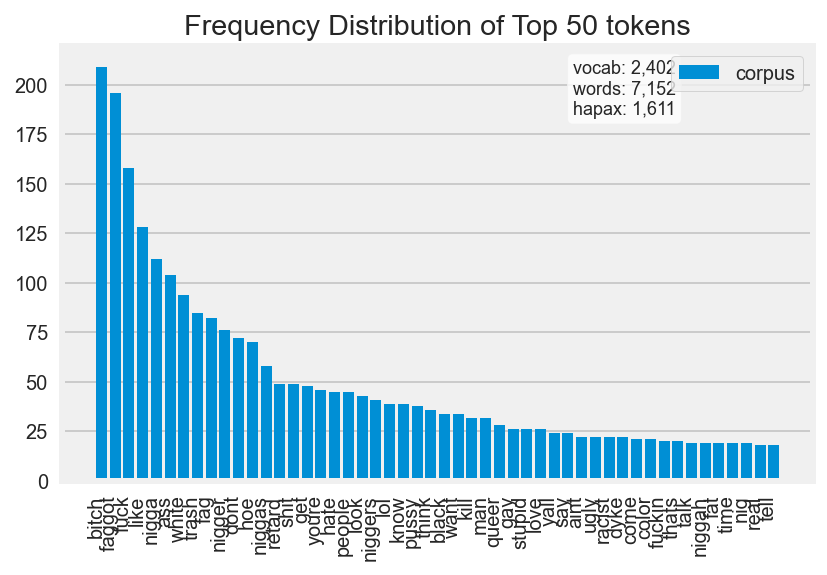

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [42]:
vec = CountVectorizer()
one_tokens = one.tweet.sum()
docs = vec.fit_transform(one_tokens)
features = vec.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

## TSNE

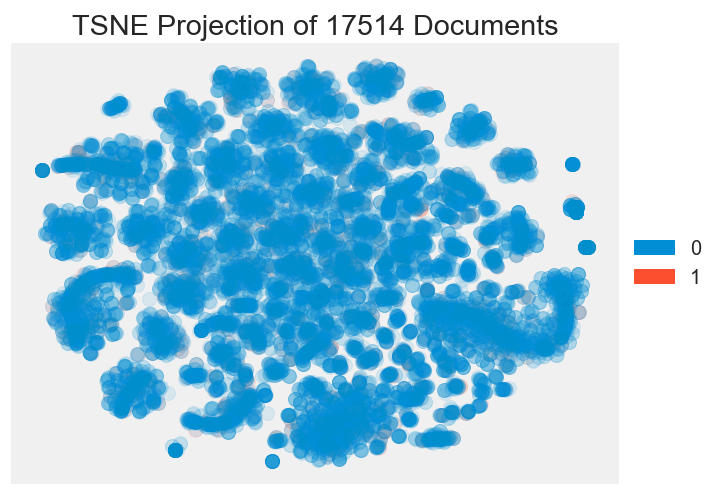

TSNEVisualizer(alpha=0.1,
               ax=<AxesSubplot:title={'center':'TSNE Projection of 17514 Documents'}>,
               decompose=None, decompose_by=None)

In [44]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(zero.tweet2)
y = train.target

tsne(X, y, alpha=0.1, decompose='svd')

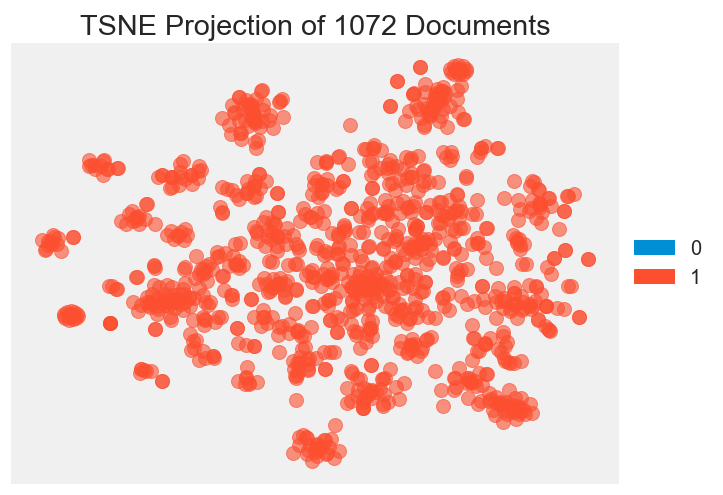

TSNEVisualizer(alpha=0.6,
               ax=<AxesSubplot:title={'center':'TSNE Projection of 1072 Documents'}>,
               decompose=None, decompose_by=None)

In [45]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(one.tweet2)
y = train.target

tsne(X, y, alpha=0.6, decompose='svd')

## Wordcloud

(-0.5, 399.5, 199.5, -0.5)

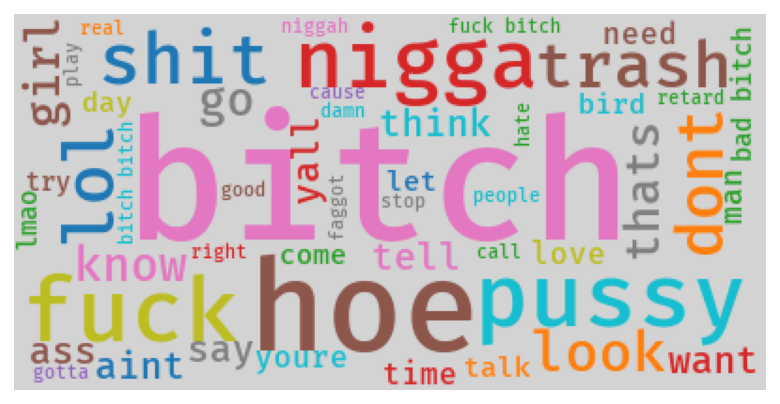

In [46]:
text = ' '.join(zero_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

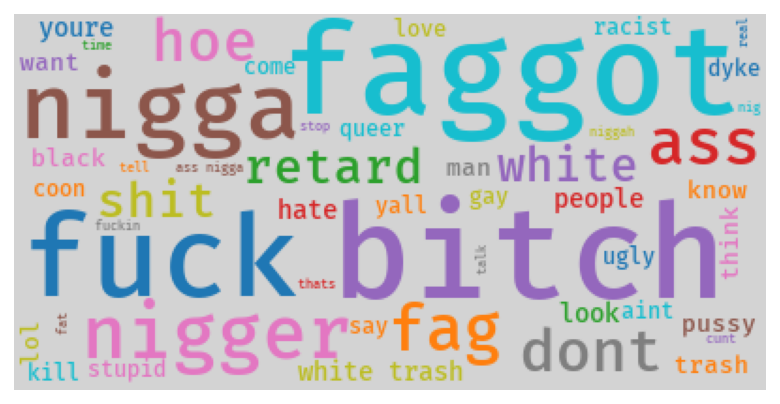

In [47]:
text = ' '.join(one_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

## Bigrams

In [57]:
def combination_of_words(df):
    return TextBlob(" ".join(train.tweet.sum())).ngrams(2)

combination_of_words(zero)[:20]

[WordList(['reject', 'constantly']),
 WordList(['constantly', 'house']),
 WordList(['house', 'threaten']),
 WordList(['threaten', 'rape']),
 WordList(['rape', 'mom']),
 WordList(['mom', 'karmas']),
 WordList(['karmas', 'bitch']),
 WordList(['bitch', 'rot']),
 WordList(['rot', 'hell']),
 WordList(['hell', 'faggot']),
 WordList(['faggot', 'convince']),
 WordList(['convince', 'lame']),
 WordList(['lame', 'nigger']),
 WordList(['nigger', 'liver']),
 WordList(['liver', 'believe']),
 WordList(['believe', 'cuz']),
 WordList(['cuz', 'nigger']),
 WordList(['nigger', 'whore']),
 WordList(['whore', 'peace']),
 WordList(['peace', 'fag'])]

In [56]:
combination_of_words(one)[:20]

[WordList(['reject', 'constantly']),
 WordList(['constantly', 'house']),
 WordList(['house', 'threaten']),
 WordList(['threaten', 'rape']),
 WordList(['rape', 'mom']),
 WordList(['mom', 'karmas']),
 WordList(['karmas', 'bitch']),
 WordList(['bitch', 'rot']),
 WordList(['rot', 'hell']),
 WordList(['hell', 'faggot']),
 WordList(['faggot', 'convince']),
 WordList(['convince', 'lame']),
 WordList(['lame', 'nigger']),
 WordList(['nigger', 'liver']),
 WordList(['liver', 'believe']),
 WordList(['believe', 'cuz']),
 WordList(['cuz', 'nigger']),
 WordList(['nigger', 'whore']),
 WordList(['whore', 'peace']),
 WordList(['peace', 'fag'])]

## Term Frequency



In [50]:
def term_frequency(df):
    tf1 = (df['tweet2'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
    tf1.columns = ['words', 'tf']
    tf1 = tf1.sort_values(by='tf', ascending=False).reset_index()
    return tf1

tf1 = term_frequency(zero)
tf1.head(10)

index     words      tf
0      5  'bitch',  6151.0
1      0   'bitch'  2190.0
2     82    'hoe',  2185.0
3     81   'like',  1885.0
4     20   'fuck',  1396.0
5     86   'dont',  1277.0
6     72  'pussy',  1179.0
7      6    'get',  1130.0
8    138    'ass',   975.0
9     95     'hoe'   945.0

In [51]:
tf2 = term_frequency(one)
tf2.head(10)

index      words     tf
0      7   'bitch',  159.0
1     50    'fuck',  153.0
2     39    'like',  119.0
3    128  'faggot',  105.0
4     63   'white',   93.0
5     71     'ass',   93.0
6      6   'faggot'   91.0
7     87   'nigga',   87.0
8    338    'dont',   72.0
9    444   'trash',   55.0

# Modeling and Metrics

In [54]:
X_tr = train.tweet2
X_val = val.tweet2
y_tr = train.target
y_val = val.target
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

## Multinomial Naive Bayes

Train Accuracy:  0.9425373937372216
Val Accuracy:  0.9426957223567393
Train F1:  0.007434944237918215
Val F1:  0.009302325581395347
Train ROC-AUC:  0.7942114325597092
Val ROC-AUC:  0.7177479383492388
Train Recall:  0.0037313432835820895
Vali Recall:  0.004672897196261682
Train Precision:  1.0
Val Precision:  1.0
Train PR-AUC:  0.304957716674489
Val PR-AUC:  0.17675788857212738


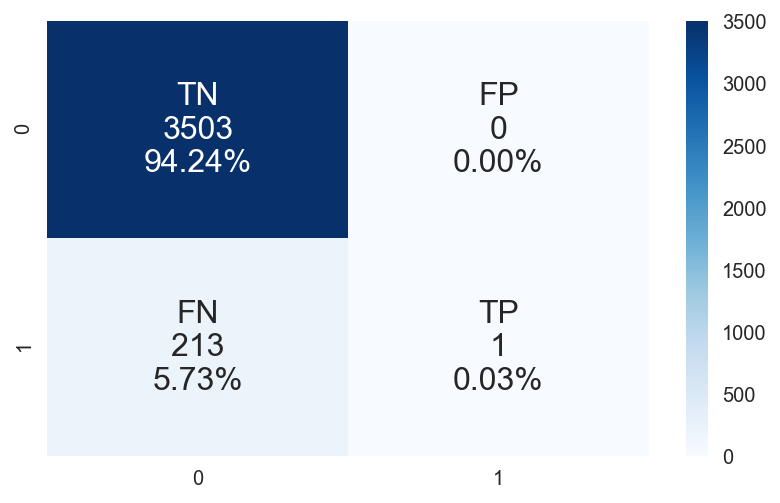

In [66]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)


## Random Forest

Train Accuracy:  0.9976864306467234
Val Accuracy:  0.9421576540220608
Train F1:  0.9799720540288775
Val F1:  0.17624521072796934
Train ROC-AUC:  0.9994279629601223
Val ROC-AUC:  0.8406339292622346
Train Recall:  0.9813432835820896
Vali Recall:  0.10747663551401869
Train Precision:  0.9786046511627907
Val Precision:  0.48936170212765956
Train PR-AUC:  0.9919820623498942
Val PR-AUC:  0.33070311779084227


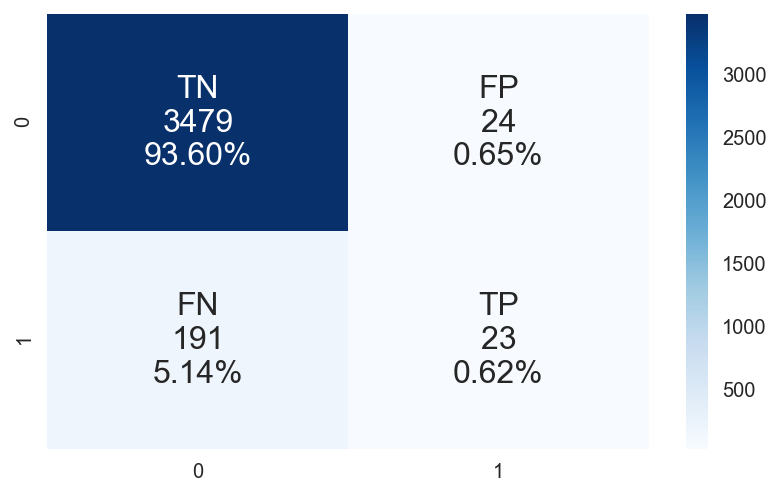

In [67]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_tr = rf.predict(tfidf_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_rf_tr, y_pr_rf_val, rf)

## Logistic Regression

Train Accuracy:  0.9470569245668783
Val Accuracy:  0.9443099273607748
Train F1:  0.22151898734177214
Val F1:  0.20077220077220076
Train ROC-AUC:  0.9460246834515329
Val ROC-AUC:  0.8743293465414158
Train Recall:  0.13059701492537312
Vali Recall:  0.12149532710280374
Train Precision:  0.7291666666666666
Val Precision:  0.5777777777777777
Train PR-AUC:  0.5666932304076191
Val PR-AUC:  0.355640424831512


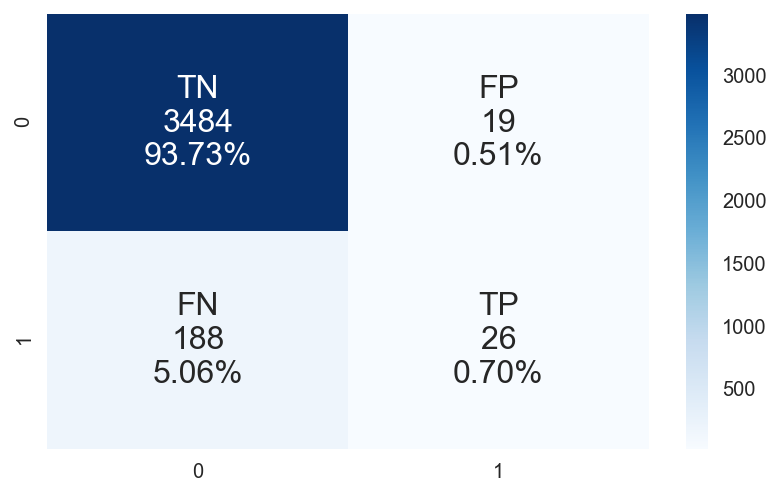

In [68]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_tr = log.predict(tfidf_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_log_tr, y_pr_log_val, log)

# Class Imbalance

## Aristotle University Dataset

Citation:

Founta, A., Djouvas, C., Chatzakou, D., Leontiadis, I., Blackburn, J., Stringhini, G., Vakali, A., Sirivianos, M. and Kourtellis, N., 2018. Large Scale Crowdsourcing and Characterization of Twitter Abusive Behavior \[Data file\]. ArXiv. Retrieved from: https://dataverse.mpi-sws.org/dataset.xhtml?persistentId=doi:10.5072/FK2/ZDTEMN

Publication: https://arxiv.org/pdf/1802.00393.pdf

In [70]:
df = pd.read_csv('data/hatespeechtwitter.csv')
df.head()

tweet_id maj_label
0  849667487180259329   abusive
1  850490912954351616   abusive
2  848791766853668864   abusive
3  848306464892604416   abusive
4  850010509969465344    normal

In [71]:
df.columns = ['id', 'label']
df.label.value_counts()

normal     52835
spam       13404
abusive    10122
hateful     3635
Name: label, dtype: int64

In [72]:
df_hateful = df[df['label']=='hateful']
df_abusive = df[df['label']=='abusive']
df_neutral = df[df['label']=='normal']


In [73]:
hate_ids = group_list(list(df_hateful.id))
len(hate_ids)

37

In [74]:
abusive_ids = group_list(list(df_abusive.id))
len(abusive_ids)

102

In [75]:
neutral_ids = group_list(list(df_neutral.id))
len(neutral_ids)

529

In [76]:
url = "https://api.twitter.com/2/tweets?ids=847661947159891972,847799130277675008,848933211375779840&tweet.fields=created_at,entities,geo,id,public_metrics,text&user.fields=description,entities,id,location,name,public_metrics,username"
payload={}
headers = {'Authorization': 'Bearer ' + keys['bearer_token'], 'Cookie': 'personalization_id="v1_hzpv7qXpjB6CteyAHDWYQQ=="; guest_id=v1%3A161498381400435837'}
r = requests.request("GET", url, headers=headers, data=payload)
data = r.json()

In [77]:
df_hate = tweets_request(hate_ids)
df_hate.head(10)

100%|██████████| 37/37 [00:23<00:00,  1.59it/s]


text                  id  \
0  I hate er chase because if the Bitch that work...  850433664890544128   
1  RT @nyctophil3: Pineapples do not belong on pi...  850100742035836929   
2  Niggas keep talking about women wearing weave ...  847804507367100416   
3  @vappywave idiot that's not gonna work. you go...  850090319165050880   
4  RT @ayevonnn: bruh i fucking hate people like ...  848686686930382848   
5  RT @mattmfm: I'm really fucking sick of watchi...  850380636300820480   
6  @JayFoee_ just another dumbass bronco fan swea...  847652946217009155   
7  RT @THESLUMPGOD: I Sampled Jaws \n\nPull Up Wi...  848835698006401024   
8  RT @arianam0lina: if you litter you're a bitch...  850215875680522240   
9  RT @cybeque: Don't take out the anger of being...  849922895132459008   

                 created_at  \
0  2017-04-07T19:42:40.000Z   
1  2017-04-06T21:39:45.000Z   
2  2017-03-31T13:35:20.000Z   
3  2017-04-06T20:58:20.000Z   
4  2017-04-03T00:00:48.000Z   
5  2017-04-07T16:11:57.000Z   
6  2017-03-31T03:33:05.000Z   
7  2017-04-03T09:52:55.000Z   
8  2017-04-07T05:17:15.000Z   
9  2017-04-06T09:53:03.000Z   

                                      public_metrics  \
0  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
1  {'retweet_count': 5, 'reply_count': 0, 'like_c...   
2  {'retweet_count': 1, 'reply_count': 0, 'like_c...   
3  {'retweet_count': 0, 'reply_count': 1, 'like_c...   
4  {'retweet_count': 5, 'reply_count': 0, 'like_c...   
5  {'retweet_count': 913, 'reply_count': 0, 'like...   
6  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
7  {'retweet_count': 6127, 'reply_count': 0, 'lik...   
8  {'retweet_count': 19, 'reply_count': 0, 'like_...   
9  {'retweet_count': 2, 'reply_count': 0, 'like_c...   

                                            entities  geo  
0                                                NaN  NaN  
1  {'mentions': [{'start': 3, 'end': 14, 'usernam...  NaN  
2                                                NaN  NaN  
3  {'mentions': [{'start': 0, 'end': 10, 'usernam...  NaN  
4  {'urls': [{'start': 53, 'end': 76, 'url': 'htt...  NaN  
5  {'annotations': [{'start': 53, 'end': 68, 'pro...  NaN  
6                                                NaN  NaN  
7  {'mentions': [{'start': 3, 'end': 15, 'usernam...  NaN  
8  {'mentions': [{'start': 3, 'end': 16, 'usernam...  NaN  
9  {'mentions': [{'start': 3, 'end': 11, 'usernam...  NaN

In [125]:
df_1 = pickle.load(open("pickle/aristotle_hate.pickle", "rb"))
df_2 = pickle.load(open("pickle/aristotle_abusive.pickle", "rb"))
df_3 = pickle.load(open("pickle/aristotle_neutral.pickle", "rb"))

In [126]:
def process_columns(df):
    df['retweets'] = df.public_metrics.apply(lambda x: x.get('retweet_count'))
    df['replies'] = df.public_metrics.apply(lambda x: x.get('reply_count'))
    df['likes'] = df.public_metrics.apply(lambda x: x.get('like_count'))
    df['quotes'] = df.public_metrics.apply(lambda x: x.get('quote_count'))
    df.drop(columns="public_metrics", axis=1, inplace=True)
    df['created'] = df.created_at.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ"))
    df.drop(columns="created_at", axis=1, inplace=True)
    df.drop(columns="geo", axis=1, inplace=True)
    df.drop(columns="entities", axis=1, inplace=True)

process_columns(df_1)
df_1.head(10)

text                  id  \
0  I hate er chase because if the Bitch that work...  850433664890544128   
1  RT @nyctophil3: Pineapples do not belong on pi...  850100742035836929   
2  Niggas keep talking about women wearing weave ...  847804507367100416   
3  @vappywave idiot that's not gonna work. you go...  850090319165050880   
4  RT @ayevonnn: bruh i fucking hate people like ...  848686686930382848   
5  RT @mattmfm: I'm really fucking sick of watchi...  850380636300820480   
6  @JayFoee_ just another dumbass bronco fan swea...  847652946217009155   
7  RT @THESLUMPGOD: I Sampled Jaws \n\nPull Up Wi...  848835698006401024   
8  RT @arianam0lina: if you litter you're a bitch...  850215875680522240   
9  RT @cybeque: Don't take out the anger of being...  849922895132459008   

   retweets  replies  likes  quotes             created  
0         0        0      0       0 2017-04-07 19:42:40  
1         5        0      0       0 2017-04-06 21:39:45  
2         1        0      3       1 2017-03-31 13:35:20  
3         0        1      1       0 2017-04-06 20:58:20  
4         5        0      0       0 2017-04-03 00:00:48  
5       916        0      0       0 2017-04-07 16:11:57  
6         0        0      0       0 2017-03-31 03:33:05  
7      6131        0      0       0 2017-04-03 09:52:55  
8        19        0      0       0 2017-04-07 05:17:15  
9         2        0      0       0 2017-04-06 09:53:03

# University of Copenhagen Dataset

** Reference: **

Waseem, Z., Hovy, D. (2016). Hateful Symbols or Hateful People? Predictive Features for Hate Speech Detection on Twitter \[Data file\]. In: *Proceedings of the NAACL Student Research Workshop*. San Diego, Calfornia: Association for Computational Linguistics, pages 88-93. Retrieved from: https://github.com/ZeerakW/hatespeech.

Publication:  https://www.aclweb.org/anthology/N16-2013.pdf

In [78]:
df2 = pd.read_csv('data/NAACL_SRW_2016.csv')
df2.columns = ['id', 'label']
df2.head()

id   label
0  572341498827522049  racism
1  572340476503724032  racism
2  572334712804384768  racism
3  572332655397629952  racism
4  575949086055997440  racism

In [79]:
df2.label.value_counts()

none      11559
sexism     3378
racism     1969
Name: label, dtype: int64

In [113]:
df_racsex = df2[(df2['label']=='racism') | (df2['label']=='sexism')]

In [ ]:
racsex_id = group_list(list(df_racsex.id))
df_rac_sex = tweets_request(racsex_id)

In [127]:
df_2 = pickle.load(open("pickle/copenhagen_2.pickle", "rb"))

In [128]:
df_2.head(10)

text                  id  \
0  Drasko they didn't cook half a bird you idiot ...  572341498827522049   
1  Hopefully someone cooks Drasko in the next ep ...  572340476503724032   
2  of course you were born in serbia...you're as ...  572334712804384768   
3  These girls are the equivalent of the irritati...  572332655397629952   
4  RT @YesYoureRacist: At least you're only a tin...  446460991396917248   
5  @MisfitInChains @oldgfatherclock @venereverita...  489938636956135424   
6  RT @Dreamdefenders: Eric Holder from #ferguson...  502315096052596736   
7  RT @AntonioFrench: I spent the morning at the ...  502508643204755456   
8  RT @harikondabolu: In his #Ferguson testimony,...  537442614534864896   
9  "He can't be a server at our restaurant, that ...  538130705382129664   

                                                 geo  \
0  {'place_id': '017453ae077eafd3', 'coordinates'...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   
8                                                NaN   
9                                                NaN   

                 created_at  \
0  2015-03-02T10:23:41.000Z   
1  2015-03-02T10:19:37.000Z   
2  2015-03-02T09:56:43.000Z   
3  2015-03-02T09:48:33.000Z   
4  2014-03-20T01:39:29.000Z   
5  2014-07-18T01:04:08.000Z   
6  2014-08-21T04:43:46.000Z   
7  2014-08-21T17:32:51.000Z   
8  2014-11-26T03:07:59.000Z   
9  2014-11-28T00:42:12.000Z   

                                      public_metrics  \
0  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
1  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
2  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
3  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
4  {'retweet_count': 46, 'reply_count': 0, 'like_...   
5  {'retweet_count': 0, 'reply_count': 2, 'like_c...   
6  {'retweet_count': 1461, 'reply_count': 0, 'lik...   
7  {'retweet_count': 1649, 'reply_count': 0, 'lik...   
8  {'retweet_count': 82, 'reply_count': 0, 'like_...   
9  {'retweet_count': 0, 'reply_count': 0, 'like_c...   

                                            entities  
0  {'hashtags': [{'start': 46, 'end': 50, 'tag': ...  
1  {'annotations': [{'start': 24, 'end': 29, 'pro...  
2  {'annotations': [{'start': 27, 'end': 32, 'pro...  
3  {'hashtags': [{'start': 95, 'end': 99, 'tag': ...  
4  {'mentions': [{'start': 3, 'end': 18, 'usernam...  
5  {'annotations': [{'start': 50, 'end': 54, 'pro...  
6  {'annotations': [{'start': 20, 'end': 30, 'pro...  
7  {'annotations': [{'start': 46, 'end': 63, 'pro...  
8  {'annotations': [{'start': 47, 'end': 59, 'pro...  
9  {'hashtags': [{'start': 103, 'end': 120, 'tag'...

In [129]:
process_columns(df_2)
df_2.head(10)

text                  id  \
0  Drasko they didn't cook half a bird you idiot ...  572341498827522049   
1  Hopefully someone cooks Drasko in the next ep ...  572340476503724032   
2  of course you were born in serbia...you're as ...  572334712804384768   
3  These girls are the equivalent of the irritati...  572332655397629952   
4  RT @YesYoureRacist: At least you're only a tin...  446460991396917248   
5  @MisfitInChains @oldgfatherclock @venereverita...  489938636956135424   
6  RT @Dreamdefenders: Eric Holder from #ferguson...  502315096052596736   
7  RT @AntonioFrench: I spent the morning at the ...  502508643204755456   
8  RT @harikondabolu: In his #Ferguson testimony,...  537442614534864896   
9  "He can't be a server at our restaurant, that ...  538130705382129664   

   retweets  replies  likes  quotes             created  
0         0        0      4       0 2015-03-02 10:23:41  
1         0        0      2       0 2015-03-02 10:19:37  
2         0        0      0       0 2015-03-02 09:56:43  
3         0        0      2       0 2015-03-02 09:48:33  
4        46        0      0       0 2014-03-20 01:39:29  
5         0        2      0       0 2014-07-18 01:04:08  
6      1461        0      0       0 2014-08-21 04:43:46  
7      1649        0      0       0 2014-08-21 17:32:51  
8        82        0      0       0 2014-11-26 03:07:59  
9         0        0      0       0 2014-11-28 00:42:12

## HASOC 2019 and 2020 Dataset

In [118]:
english = pd.read_csv("data/english_dataset.tsv", delimiter="\t")
english.head()

text_id                                               text task_1  \
0  hasoc_en_1  #DhoniKeepsTheGlove | WATCH: Sports Minister K...    NOT   
1  hasoc_en_2  @politico No. We should remember very clearly ...    HOF   
2  hasoc_en_3  @cricketworldcup Guess who would be the winner...    NOT   
3  hasoc_en_4  Corbyn is too politically intellectual for #Bo...    NOT   
4  hasoc_en_5  All the best to #TeamIndia for another swimmin...    NOT   

  task_2 task_3  
0   NONE   NONE  
1   HATE    TIN  
2   NONE   NONE  
3   NONE   NONE  
4   NONE   NONE

In [117]:
neutral = english[english['task_1'] == 'NOT']
neutral.head()

text_id                                               text task_1  \
0  hasoc_en_1  #DhoniKeepsTheGlove | WATCH: Sports Minister K...    NOT   
2  hasoc_en_3  @cricketworldcup Guess who would be the winner...    NOT   
3  hasoc_en_4  Corbyn is too politically intellectual for #Bo...    NOT   
4  hasoc_en_5  All the best to #TeamIndia for another swimmin...    NOT   
5  hasoc_en_6  @kellymiller513 @TheRealOJ32 I hope you rememb...    NOT   

  task_2 task_3  
0   NONE   NONE  
2   NONE   NONE  
3   NONE   NONE  
4   NONE   NONE  
5   NONE   NONE

In [119]:
hate = english[english['task_2'] == 'HATE']
hate.head()

text_id                                               text task_1  \
1    hasoc_en_2  @politico No. We should remember very clearly ...    HOF   
11  hasoc_en_12  I don’t know how much more I can take! 45 is a...    HOF   
23  hasoc_en_24  #ShameOnICC  1. ICC on Dhoni's gloves         ...    HOF   
27  hasoc_en_28  Disgusting! And they don’t change their cultur...    HOF   
34  hasoc_en_35  @TheRealOJ32 Of all the retired NFL players, w...    HOF   

   task_2 task_3  
1    HATE    TIN  
11   HATE    TIN  
23   HATE    TIN  
27   HATE    TIN  
34   HATE    TIN